In [9]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
from tqdm.notebook import tqdm
import webrtcvad
from matplotlib import pyplot as plt
import soundfile
import pickle

In [10]:
import IPython.display
import numpy as np
import json

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float32Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

In [3]:
### Setup paths and directories
dataset_path = ".."
rawdata_path = os.path.join(dataset_path, "raw")
out_path = "raw"
metadata_path = os.path.join(dataset_path, "metadata_compiled.csv")

In [4]:
metadata = pd.read_csv(metadata_path, sep = ",")
#print(metadata.columns)

# convert strings 'True'/'False' to genuine booleans
cols_to_boolean = (['respiratory_condition', 'fever_muscle_pain',
                     'dyspnea_1', 'wheezing_1', 'stridor_1','choking_1', 'congestion_1', 'nothing_1',
                     'dyspnea_2', 'wheezing_2', 'stridor_2','choking_2', 'congestion_2', 'nothing_2',
                     'dyspnea_3', 'wheezing_3', 'stridor_3','choking_3', 'congestion_3', 'nothing_3',
                     'dyspnea_4', 'wheezing_4', 'stridor_4','choking_4', 'congestion_4', 'nothing_4'])
for c in cols_to_boolean:
    metadata.loc[metadata[c].notnull(), c] = metadata.loc[metadata[c].notnull(), c].astype(bool) 

# Data cleaning
print("Metadata df entries before cleaning NAs: {}".format(metadata.shape[0]))

# remove entries where status is NA
metadata = metadata.loc[metadata['status'].notnull()]
# remove entries where cough_detected is low
metadata = metadata.loc[metadata['cough_detected'] >= 0.8]

print("Metadata df entries after cleaning NAs: {}".format(metadata.shape[0]))



Metadata df entries before cleaning NAs: 27550
Metadata df entries after cleaning NAs: 10819


In [5]:
metadata['audio_class'] = 'X' # default, we should have none by the end of this classification process
metadata.loc[metadata['status'] == "COVID-19", 'audio_class'] = 1
metadata.loc[metadata['status'] == "healthy", 'audio_class'] = 0
# metadata.loc[metadata['status'] == "symptomatic", 'audio_class'] = 2

print("Entries subdivided in classes. Printing the number of entries for each class:")
print(metadata[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

print("\n\n\nSplitting count by class and status:")
print(metadata[['audio_class','status','uuid']].groupby(['audio_class','status']).count().rename(columns={'uuid':'N_entries'}) )


Entries subdivided in classes. Printing the number of entries for each class:
             N_entries
audio_class           
0                 8300
1                  699
X                 1820



Splitting count by class and status:
                         N_entries
audio_class status                
0           healthy           8300
1           COVID-19           699
X           symptomatic       1820


In [6]:
validdata = metadata.loc[(metadata['audio_class'] != 'X')]
print(validdata[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

             N_entries
audio_class           
0                 8300
1                  699


In [7]:
# Balance the number of each classes
num = len(validdata.loc[validdata["audio_class"] == 1])

# balanced_data = pd.concat([
#     validdata.loc[validdata["audio_class"] == 1],
#     validdata.loc[validdata["audio_class"] == 0].sample(n = num),
#     validdata.loc[validdata["audio_class"] == 2].sample(n = num)
# ])

balanced_data = pd.concat([
    validdata.loc[validdata["audio_class"] == 1],
    validdata.loc[validdata["audio_class"] == 0].sample(n = num)
    # validdata.loc[validdata["audio_class"] == 2].sample(n = num)
])

In [8]:
print(balanced_data[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

             N_entries
audio_class           
0                  699
1                  699


In [10]:
def float_to_pcm16(audio):

    ints = (audio * 32767).astype(np.int16)
    little_endian = ints.astype('<u2')
    buf = little_endian.tobytes()
    return buf

def read_pcm16(path):

    audio, sample_rate = librosa.load(path, sr = None)
    assert sample_rate in (8000, 16000, 32000, 48000)
    pcm_data = float_to_pcm16(audio)
    return pcm_data, sample_rate

In [11]:
def detectVoiceActivity (pcm16, sample_rate, frame_duration = 0.01, vad_mode = 0):
    vad = webrtcvad.Vad()
    vad.set_mode(vad_mode)
    vad_res = []

    frame_bytes = int(sample_rate * frame_duration * 2)
    # Padding with zeros to get whole frames
    pcm16 += b'\x00' * (-len(pcm16) % frame_bytes)

    for frame in [pcm16[i: i + frame_bytes] for i in range(0, len(pcm16), frame_bytes)]:
        vad_res.append(vad.is_speech(frame, sample_rate))

    return np.asarray(vad_res)


In [38]:
def sampleVoiceActivity(signal, vad_res, frame_duration, sample_rate, active_duration = 0.3, sample_duration = 1): 
    sample = None
    start = None
    for i in range(len(vad_res) - int(max(active_duration, sample_duration) / frame_duration)):
        if np.all(vad_res[i: i + int(active_duration / frame_duration)]):
            start = i * int(frame_duration * sample_rate)
            end = int((i * frame_duration + sample_duration) * sample_rate)
            sample = signal[start: end]
            break
    if sample is None:
        print("ERROR: No active voice detected")
    return sample, start

In [83]:
filename = balanced_data.values[2, 0] + '.webm'
file_path = os.path.join(rawdata_path, filename)
signal, sr = librosa.load(file_path, sr = None)

d:\ProgramData\Anaconda3\envs\fcan\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [84]:
pcm16 = float_to_pcm16(signal)
frame_duration = 0.01
vad_mode = 3
vad_res = detectVoiceActivity(pcm16, sr, frame_duration, vad_mode)
sample, start = sampleVoiceActivity(signal, vad_res, frame_duration, sr)

In [85]:
Audio(sample, sr)

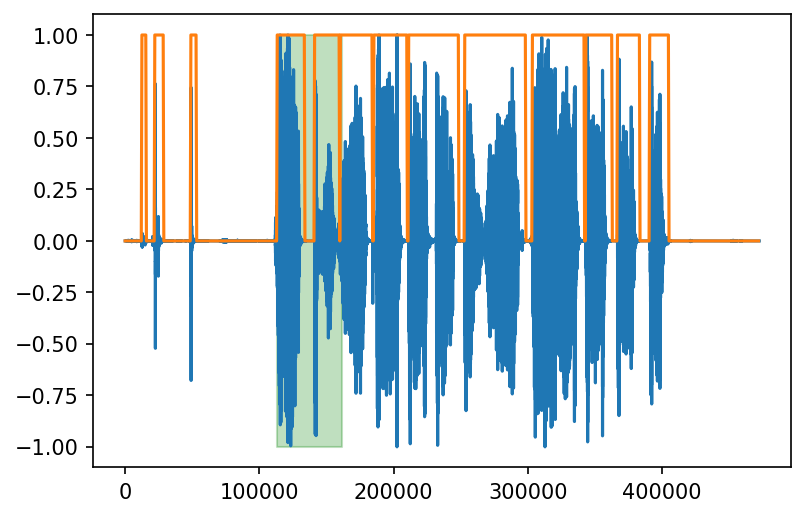

In [86]:
plt.figure(dpi=150)
plt.plot(signal)
plt.plot(np.arange(len(vad_res)) * sr * frame_duration, np.asarray(vad_res).astype("int"))
plt.fill_betweenx([-1, 1], [start, start], [start + sr, start + sr], color = "green", alpha = 0.25)

In [75]:
frame_duration = 0.01
vad_mode = 3
active_duration = 0.3
sample_duration = 1

sampled_data = balanced_data

for uuid in tqdm(balanced_data["uuid"].values):

    if os.path.exists(os.path.join("raw", uuid + ".wav")):
        continue

    filename = uuid + ".webm"
    file_path = os.path.join(rawdata_path, filename)
    if not os.path.exists(file_path):
        # try to look for a .ogg file
        filename = uuid + ".ogg"
        file_path = os.path.join(rawdata_path, filename)
        if not os.path.exists(file_path):
            print(f"could not find audio file for uuid: {uuid}")
            continue

    signal, sr = librosa.load(file_path, sr = None)
    pcm16 = float_to_pcm16(signal)
    vad_res = detectVoiceActivity(pcm16, sr, frame_duration, vad_mode)
    sample, start = sampleVoiceActivity(signal, vad_res, frame_duration, sr)

    if sample is None:
        sampled_data.drop(sampled_data.loc[sampled_data.uuid == uuid].index, inplace = True)
        continue

    soundfile.write(os.path.join(out_path, uuid + ".wav"), sample, sr)

  0%|          | 0/1392 [00:00<?, ?it/s]

ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected
ERROR: No active voice detected


In [78]:
sampled_data.to_csv("metadata.csv")

In [87]:
### Setup paths and directories
dataset_path = "."
rawdata_path = os.path.join(dataset_path, "raw")
metadata_path = os.path.join(dataset_path, "metadata.csv")

In [88]:
metadata = pd.read_csv(metadata_path, sep = ",")

In [90]:
print(balanced_data[['audio_class','uuid']].groupby(['audio_class']).count().rename(columns={'uuid':'N_entries'}) )

             N_entries
audio_class           
0                  686
1                  691


In [166]:
mfccs = {}
fix_length = 48000
n_mfcc = 15
n_fft = 1024 # about 20ms per frame
hop_length = 512

for uuid, audio_class in tqdm(zip(metadata["uuid"].values, metadata["audio_class"].values), total = len(metadata)):

    filename = uuid + ".wav"
    file_path = os.path.join(rawdata_path, filename)

    if not os.path.exists(file_path):
        print(f"could not find audio file for uuid: {uuid}")
        continue

    signal, sr = librosa.load(file_path, sr = None)

    signal = librosa.util.fix_length(signal, size = fix_length)
    mfcc = librosa.feature.mfcc(y = signal, n_mfcc = n_mfcc, n_fft = n_fft, hop_length = hop_length)
    mfcc = mfcc.T
    mfccs[uuid] = (mfcc, audio_class)


  0%|          | 0/1377 [00:00<?, ?it/s]

In [168]:
filename = f"mfcc_fixlength_{fix_length}_nmfcc_{n_mfcc}_nfft_{n_fft}_hoplength_{hop_length}.pkl"

In [169]:
with open(filename, "wb") as f:
    pickle.dump(mfccs, f)

In [170]:
with open(filename, "rb") as f:
    mfccs_reloaded = pickle.load(f)

In [1]:
librosa.display.specshow(list(mfccs_reloaded.values())[110][0].T)

NameError: name 'librosa' is not defined

In [11]:
signals_path = r"signals.pkl"
mfccs_path = r"mfcc_fixlength_48000_nmfcc_15_nfft_1024_hoplength_512.pkl"
with open(mfccs_path, "rb") as f:
    filename_mfccs = pickle.load(f)
with open(signals_path, "rb") as f:
    signals = pickle.load(f)

In [12]:
mfccs = []
for filename in signals["filename"]:
    mfccs.append(filename_mfccs[filename][0])

In [13]:
mfccs = np.asarray(mfccs)

In [14]:
mfccs.shape

(1377, 94, 15)

In [15]:
np.save("mfcc_fixlength_48000_nmfcc_15_nfft_1024_hoplength_512.npy", mfccs)

In [18]:
s = np.asarray(signals["signal"])

In [21]:
s2 = s[:, :30720]

In [22]:
s2

(1377, 30720)

In [28]:
mfccs = []
fix_length = 30720
n_mfcc = 39
n_fft = 2048 # about 20ms per frame
hop_length = 1024

for s in s2:
    mfcc = librosa.feature.mfcc(y = s, n_mfcc = n_mfcc, n_fft = n_fft, hop_length = hop_length)
    mfcc = mfcc.T
    mfccs.append(mfcc)

In [29]:
mfccs = np.asarray(mfccs)

In [30]:
mfccs.shape

(1377, 31, 39)

In [31]:
np.save("mfcc39_fixlength_30720_nmfcc_39_framelength_2048_hoplength_1024.npy", mfccs)